## 1. Wczytanie i skalowanie wartości pikseli obrazu

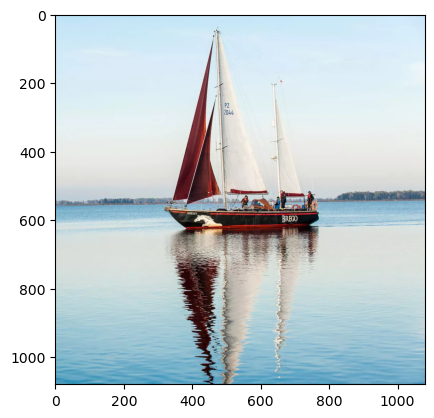

In [6]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('brego-full-crop.jpg')

# konwersja obrazu na tensor i normalizacja wartości do [0,1]
transform = transforms.Compose([
    transforms.ToTensor()
])
image_rgb = transform(img)

plt.imshow(image_rgb.permute(1, 2, 0).numpy())
plt.show()

## 2. Konwersja obrazu na skalę szarości

torch.Size([1080, 1080])


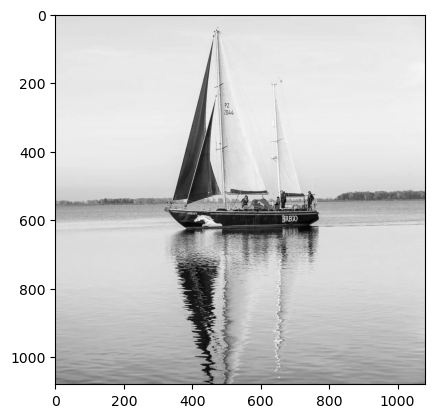

In [7]:
# wymiary kernela: (out_channels, in_channels, height, width)
greyscale_kernel = torch.tensor([[[[0.4]], [[0.3]], [[0.3]]]])  # Shape: (1, 3, 1, 1)

# robimy konwolucje na obrazie uzywajac powyzszego kernela
# Note: 'conv2d' expects a 4D tensor (batch_size, channels, height, width)
image_gs = F.conv2d(image_rgb, greyscale_kernel)

# usuwamy wymiar na batch size i juz niepotrzebny na 3 wartosci kolorow, zostaje 2d z wartoscia kazdego piksela
image_gs = image_gs.squeeze(0).squeeze(0)

plt.imshow(image_gs.detach().numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()

## 3. Pooling - redukcja rozmiaru

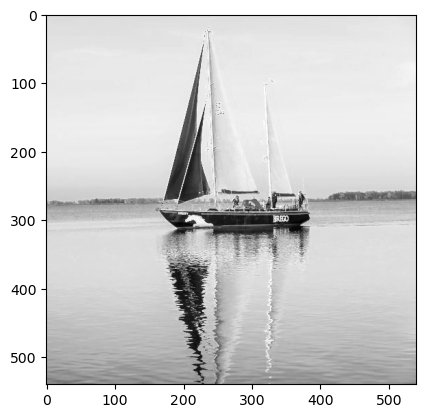

In [21]:
# pooling o wymiarze 2x2
pool = torch.nn.MaxPool2d(2)
image_small_gs = pool(image_gs.unsqueeze(0))
plt.imshow(image_small_gs.squeeze(), cmap="gray", vmin=0, vmax=1)
plt.show()


## 4. Rozmycie Gaussowskie

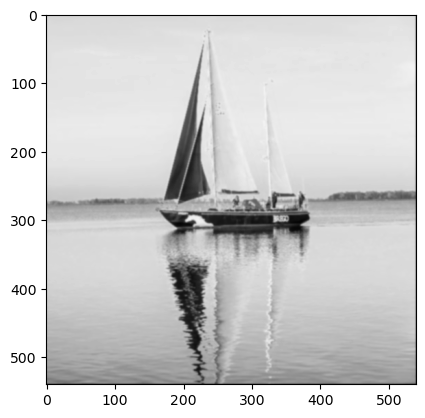

In [93]:
import numpy as np

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

gaussian_kernel_tensor = torch.tensor(gaussian_kernel(5), dtype=torch.float32)

image_small_gs = image_small_gs.squeeze(0)

image_blurred = F.conv2d(image_small_gs.unsqueeze(0).unsqueeze(0), gaussian_kernel_tensor.unsqueeze(0).unsqueeze(0), stride=1, padding=2).squeeze().squeeze()

plt.imshow(image_blurred, cmap="gray", vmin=0, vmax=1)
plt.show()

## 5. Obliczenie gradientów intensywności zmiany koloru 

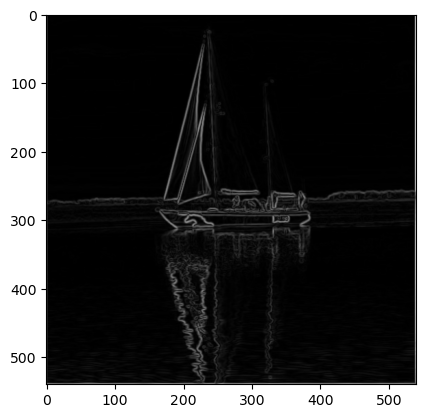

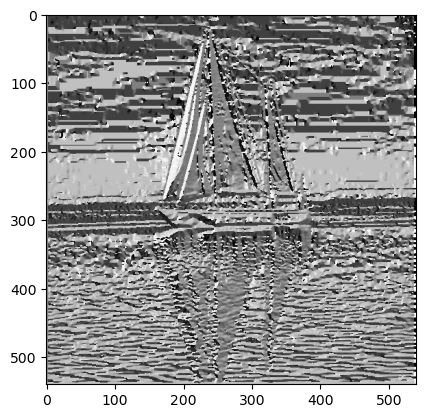

In [103]:
def sobel_filters(img):
    Kx = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    Ky = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    img = img.unsqueeze(0).unsqueeze(0).float()

    Ix = F.conv2d(img, Kx, padding=1)
    Iy = F.conv2d(img, Ky, padding=1) 

    G = torch.hypot(Ix, Iy) 
    G = G / G.max() * 255

    theta = torch.atan2(Iy, Ix) 

    return G, theta

gradient_value, gradient_direction = sobel_filters(image_blurred)

plt.imshow(gradient_value.squeeze().squeeze(), cmap="gray")
plt.show()
plt.imshow(gradient_direction.squeeze().squeeze(), cmap="gray")
plt.show()


## 6. "Odchudzenie" krawędzi

In [113]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

image_thin_edges = torch.tensor(non_max_suppression(gradient_value.squeeze().squeeze(), gradient_direction.squeeze().squeeze()))


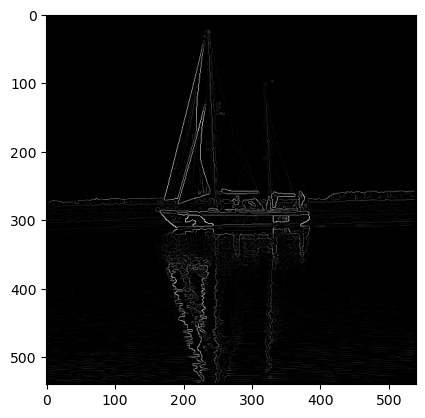

In [114]:
plt.imshow(image_thin_edges, cmap="gray")
plt.show()

## 7. Odfiltrowanie rejonów z niewielkim gradientem

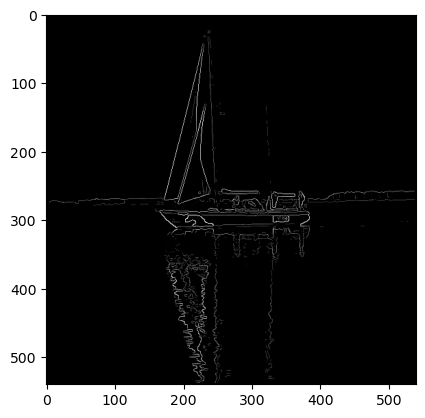

In [132]:
image_thin_edges_tresholded = F.threshold(image_thin_edges, 25, 0)
plt.imshow(image_thin_edges_tresholded, cmap="gray")
plt.show()

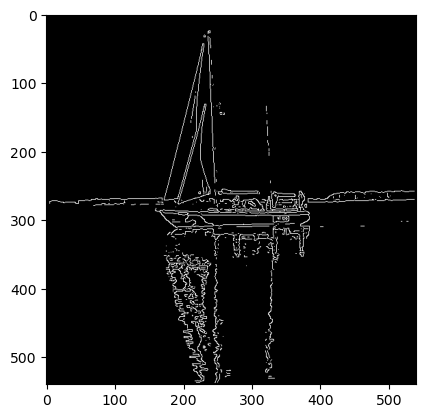

In [137]:
def normalize(image: torch.Tensor):
    normalized_image = (image != 0)
    return normalized_image

final_edges = normalize(image_thin_edges_tresholded).float()

plt.imshow(final_edges, cmap="gray", vmin=0, vmax=1)
plt.show()

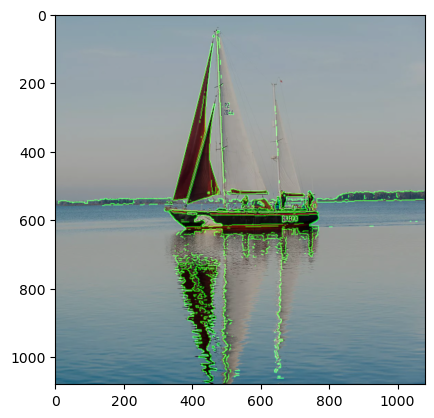

In [153]:
def upscale_and_combine_edges_with_image(edges: torch.Tensor, original_image: torch.Tensor):  

    upscaled_edges = F.interpolate(edges.unsqueeze(0).unsqueeze(0), size=original_image.shape[1:], mode='bilinear', align_corners=False)
    upscaled_edges = upscaled_edges.squeeze(0).squeeze(0)

    combined_image = original_image.clone()

    combined_image[0] *= 0.7
    combined_image[1] *= 0.7
    combined_image[2] *= 0.7
    combined_image[1] += upscaled_edges

    combined_image = torch.clamp(combined_image, 0, 1)

    return combined_image

final_image = upscale_and_combine_edges_with_image(final_edges, image_rgb)

plt.imshow(final_image.permute(1, 2, 0).cpu().numpy())
plt.show()
